In [1]:
import os

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
csv_dir = '../my-data'
dfs_1, dfs_2 = [], []
for csv in os.listdir(csv_dir):
    df = pd.read_csv(os.path.join(csv_dir, csv), index_col=0, dtype=float)
    df.drop(columns=["0.5"], inplace=True)
    if csv.endswith('1.csv'):
        dfs_1.append(df)
    elif csv.endswith('2.csv'):
        dfs_2.append(df)

chiller_temps = [pd.concat(dfs) for dfs in zip(dfs_1, dfs_2)]
df_concat = pd.concat(chiller_temps)
df_grouped = df_concat.groupby(df_concat.index)
avg_temp = df_grouped.mean()
avg_temp.drop(index=[210.0, 240.0, 270.0, 300.0, 330.0], inplace=True)
avg_temp.head(13)

,1.25,2.0,2.75,3.5,4.25,5.0,5.75,6.5,7.25
0.0,1.360195,1.303995,1.906685,2.800230,3.331275,4.389140,5.096230,5.120160,5.192810
30.0,1.243320,2.047050,2.623735,2.867975,2.898135,3.044935,3.667295,4.119930,4.673945
60.0,2.101070,2.290080,2.798130,3.093140,3.340425,3.388685,3.614315,4.015890,4.392805
90.0,1.531960,1.745265,1.866900,2.135470,2.318210,2.345640,2.346175,2.316240,2.505455
120.0,1.898960,2.623795,3.038300,3.067085,3.002945,2.915115,2.791730,2.651570,2.513745
150.0,1.658845,2.332325,2.845960,2.949025,2.898245,2.760440,2.587580,2.448930,2.318640
180.0,1.661300,2.186055,2.747570,2.866275,2.688655,2.466415,2.270890,2.071465,1.916750


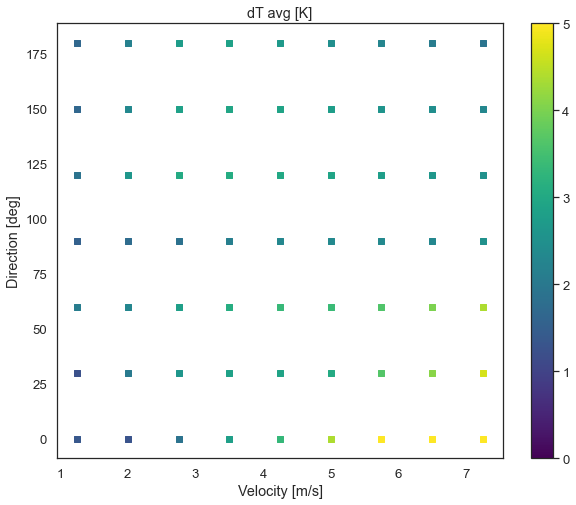

In [45]:
X1_obs = [float(i) for i in avg_temp.columns.tolist()]
X2_obs = [float(i) for i in avg_temp.index.tolist()]
x1, x2 = np.meshgrid(X1_obs, X2_obs)
x11 = sum(x1.tolist(), [])
x22 = sum(x2.tolist(), [])
# x1, x2 = np.meshgrid(np.linspace(0,360,nx1), np.linspace(0,8,nx2))
# X = np.concatenate([x1.reshape(nx1*nx2, 1), x2.reshape(nx1*nx2, 1)], 1)

# X1_obs = chiller_temp.columns.tolist()
# X2_obs = chiller_temp.index.tolist()
y_obs = sum(avg_temp.values.tolist(), [])

with sns.axes_style("white"):
    plt.figure(figsize=(10,8))
    plt.scatter(x11, x22, c=y_obs, marker='s', cmap=plt.cm.viridis, vmin=0, vmax=5)
    plt.xlabel("Velocity [m/s]")
    plt.ylabel("Direction [deg]")
    plt.title("dT avg [K]")
    plt.colorbar()

In [37]:
print(y_obs)

[1.3601950000000245, 1.3039950000000176, 1.9066850000000215, 2.800230000000016, 3.331275000000025, 4.389140000000023, 5.0962300000000225, 5.120160000000022, 5.1928100000000255, 1.2433200000000226, 2.0470500000000214, 2.623735000000022, 2.867975000000024, 2.8981350000000163, 3.0449350000000153, 3.667295000000024, 4.11993000000003, 4.673945000000026, 2.1010700000000297, 2.290080000000023, 2.798130000000026, 3.0931400000000195, 3.340425000000022, 3.388685000000021, 3.6143150000000217, 4.015890000000018, 4.392805000000027, 1.5319600000000206, 1.7452650000000176, 1.866900000000021, 2.135470000000018, 2.318210000000019, 2.3456400000000173, 2.346175000000025, 2.3162400000000303, 2.505455000000029, 1.898960000000025, 2.623795000000024, 3.038300000000018, 3.0670850000000227, 3.002945000000017, 2.9151150000000228, 2.791730000000021, 2.6515700000000235, 2.5137450000000228, 1.658845000000022, 2.332325000000023, 2.8459600000000194, 2.9490250000000175, 2.898245000000017, 2.7604400000000195, 2.587580

Text(0.5, 118.5, 'Prędkość wiatru [m/s]')

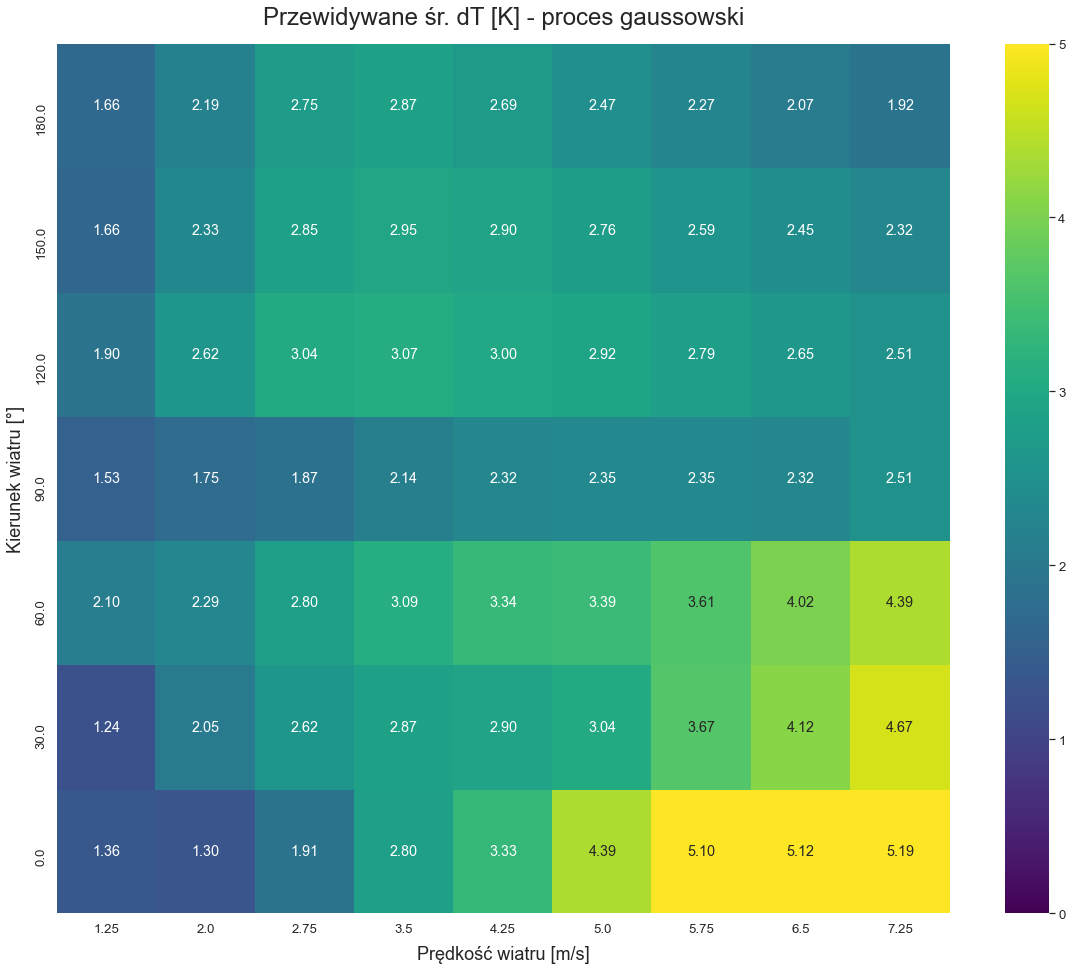

In [43]:
dT = np.reshape(y_obs, (len(X2_obs), len(X1_obs)))

plt.figure(figsize=(20,16))
sns.set(font_scale=1.2)
ax = sns.heatmap(dT, vmin=0, vmax=5, annot=True, fmt='.2f', cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(avg_temp.index)
ax.set_xticklabels(avg_temp.columns)
ax.set_title('Przewidywane śr. dT [K] - proces gaussowski', fontsize=24, y=1.015)
ax.set_ylabel('Kierunek wiatru [\N{DEGREE SIGN}]', fontsize=18, labelpad=10)
ax.set_xlabel('Prędkość wiatru [m/s]', fontsize=18, labelpad=10)

In [5]:
X_obs = np.concatenate([x1.reshape(len(x1)*len(x1[0]), 1), x2.reshape(len(x2)*len(x2[0]), 1)], axis=1)

In [6]:
RANDOM_SEED = 42
CHAINS = 4

In [7]:
with pm.Model() as model_1:
    
    # l1 = pm.StudentT("l1", nu=5, mu=3, sigma=2)
    l1_1 = pm.Normal("l1", mu=3, sigma=1)
    # l2 = pm.StudentT("l2", nu=15, mu=30, sigma=10)
    l2_1 = pm.Normal("l2", mu=30, sigma=2)
    sf_1 = pm.HalfCauchy("sf", 2)
    sn_1 = pm.HalfNormal("sn", 0.2)

    #M = pm.gp.mean.Constant([2.5])
    M_1 = pm.gp.mean.Zero()
    K_1 = pm.gp.cov.ExpQuad(2, [l1_1, l2_1]) * sf_1**2
    
    gp_chillers_1 = pm.gp.Marginal(mean_func=M_1, cov_func=K_1)
    obs_1 = gp_chillers_1.marginal_likelihood("obs_1", X=X_obs, y=y_obs, noise=sn_1)

    # mp = pm.find_MAP()

In [8]:
with pm.Model() as model_2:
    
    #l1_2 = pm.Normal("l1", mu=5, sigma=2)
    #l1_2 = pm.ChiSquared("l1", nu=6)
    #l1_2 = pm.ExGaussian("l1", mu=5, sigma=2, nu=1)
    #l1_2 = pm.Gamma("l1", mu=5, sigma=3)
    l1_2 = pm.Rice("ls", nu=3, sigma=1)
    #l1_2 = pm.Normal("ls", mu=0, sigma=5)
    #l2_2 = pm.ChiSquared("l2", nu=15)
    #l2_2 = pm.ExGaussian("l2", mu=40, sigma=10, nu=1)
    #l2_2 = pm.Gamma("l2", mu=30, sigma=10)
    l2_2 = pm.Rice("ld", nu=30, sigma=2)
    #l2_2 = pm.Normal("ld", mu=0, sigma=40)
    #sf_2 = pm.HalfCauchy("sf", 2)
    #sf_2 = pm.HalfStudentT("sf", sigma=3, nu=1)
    sf_2 = pm.Rice("sf", nu=0, sigma=1)
    sn_2 = pm.HalfNormal("sn", 0.17)

    #M = pm.gp.mean.Constant([2.5])
    M_2 = pm.gp.mean.Zero()
    K_2 = pm.gp.cov.ExpQuad(2, [l1_2, l2_2]) * sf_2**2
    
    gp_chillers_2 = pm.gp.Marginal(mean_func=M_2, cov_func=K_2)
    obs_2 = gp_chillers_2.marginal_likelihood("obs_2", X=X_obs, y=y_obs, noise=sn_2)

In [9]:
with model_1:
    gp_trace_1 = pm.sample(1000, tune=2000, cores=8, chains=CHAINS, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [sn, sf, l2, l1]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 42 seconds.


In [10]:
with model_2:
    gp_trace_2 = pm.sample(1000, tune=2000, cores=8, chains=CHAINS, random_seed=RANDOM_SEED)

WARNING (theano.tensor.opt): Optimization Warning: The Op i0e does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.opt): Optimization Warning: The Op i1e does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [sn, sf, ld, ls]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 42 seconds.


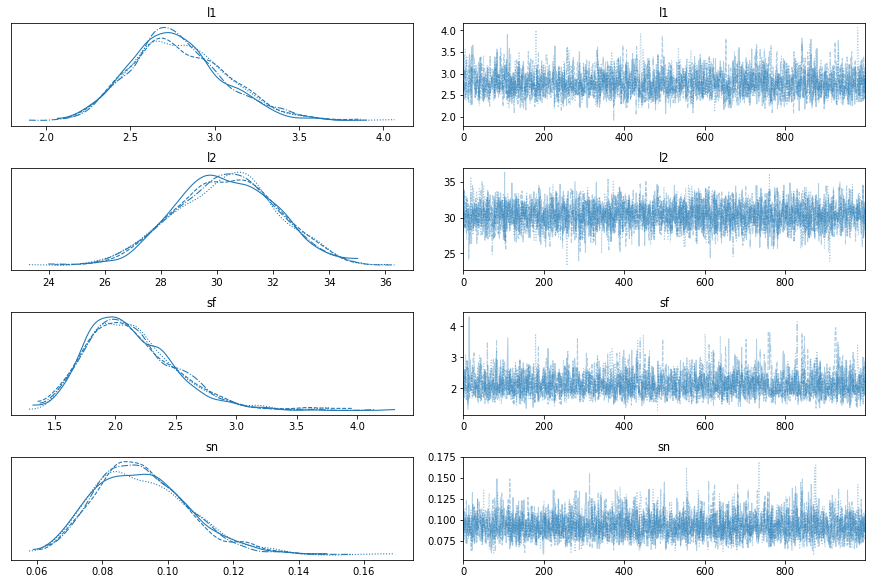

In [11]:
az.plot_trace(gp_trace_1, var_names=['l1', 'l2', 'sf', 'sn']);

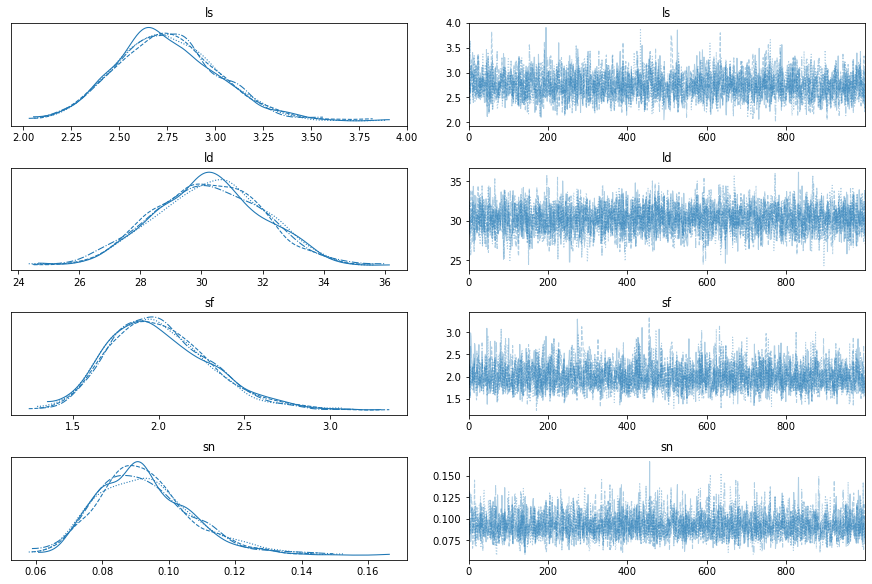

In [12]:
az.plot_trace(gp_trace_2, var_names=['ls', 'ld', 'sf', 'sn']);

array([<AxesSubplot:title={'center':'l1'}>,
       <AxesSubplot:title={'center':'l2'}>,
       <AxesSubplot:title={'center':'sf'}>,
       <AxesSubplot:title={'center':'sn'}>], dtype=object)

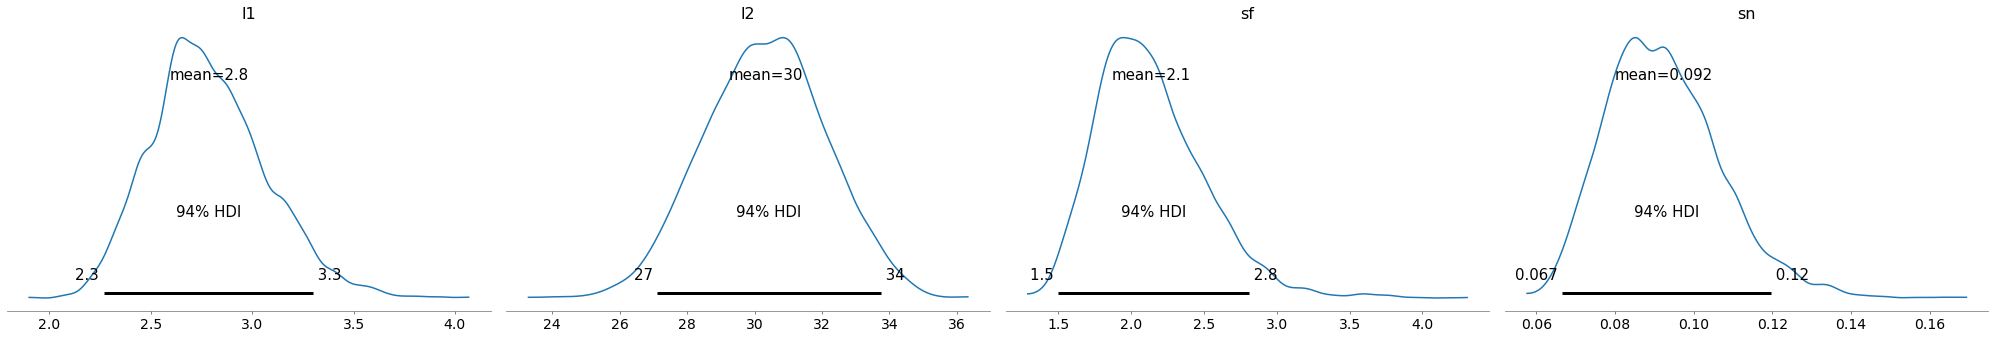

In [13]:
az.plot_posterior(gp_trace_1)

array([<AxesSubplot:title={'center':'ls'}>,
       <AxesSubplot:title={'center':'ld'}>,
       <AxesSubplot:title={'center':'sf'}>,
       <AxesSubplot:title={'center':'sn'}>], dtype=object)

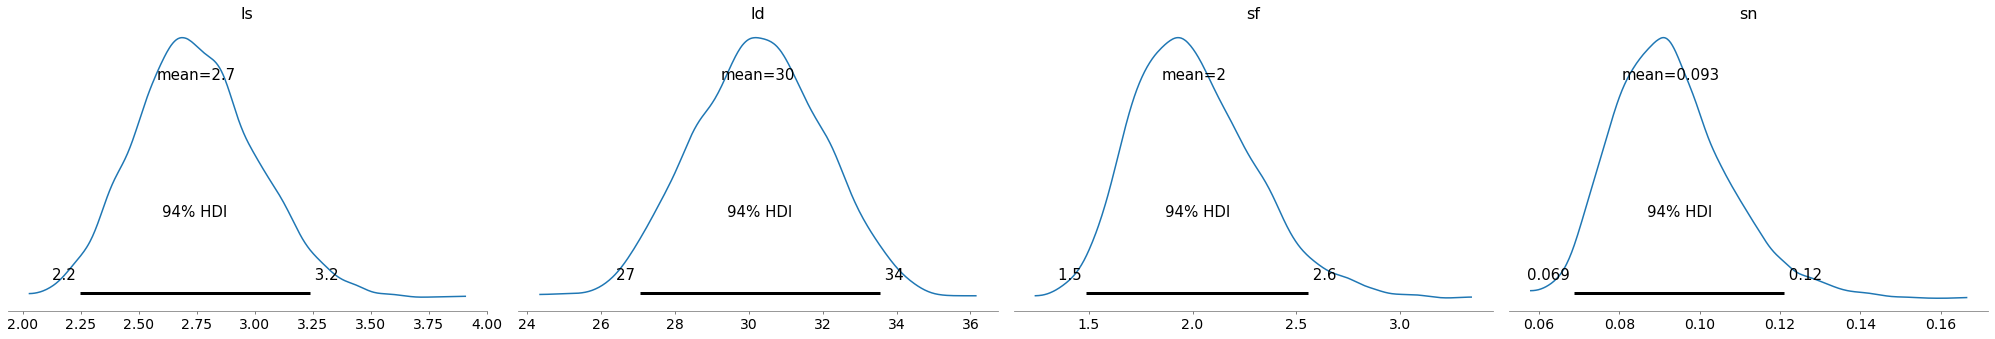

In [14]:
az.plot_posterior(gp_trace_2)

array([<AxesSubplot:title={'center':'94.0% HDI'}>,
       <AxesSubplot:title={'center':'ess'}>,
       <AxesSubplot:title={'center':'r_hat'}>], dtype=object)

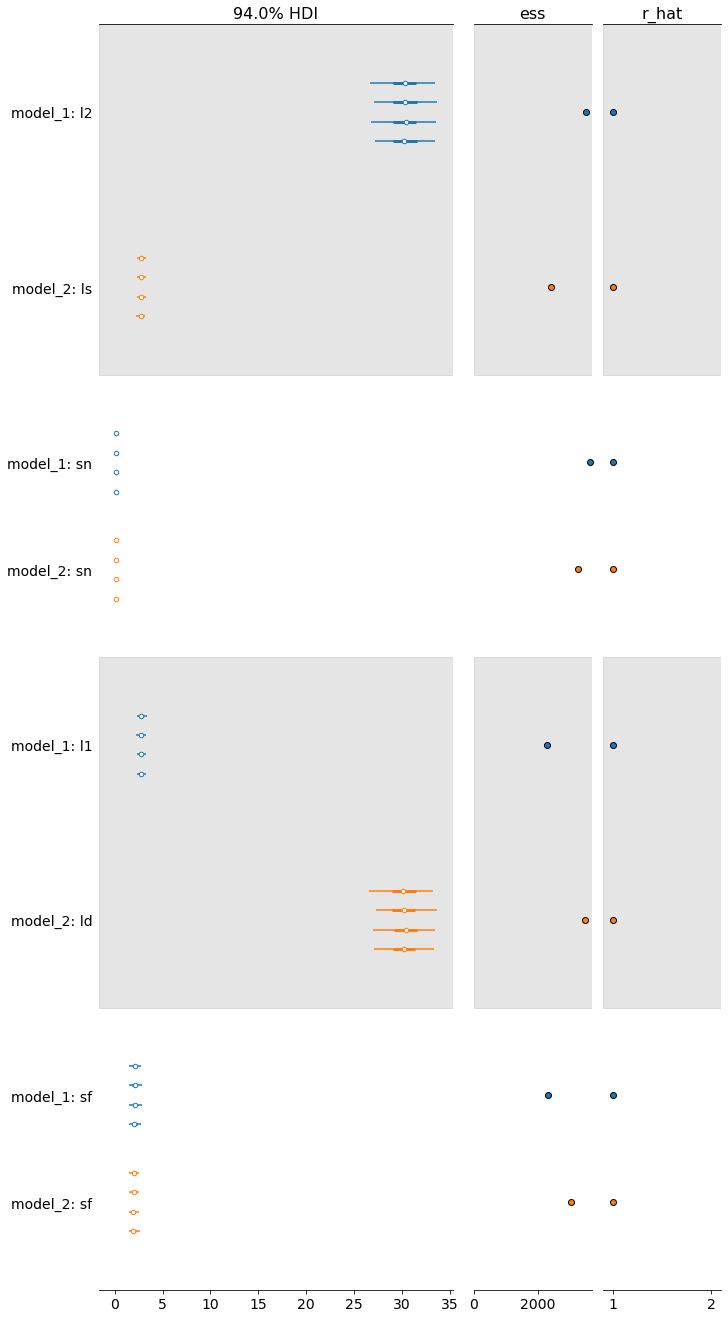

In [15]:
az.plot_forest([gp_trace_1, gp_trace_2], model_names=['model_1', 'model_2'], ess=True, r_hat=True)

In [16]:
az.summary(gp_trace_1, round_to=3, var_names=['l1', 'l2', 'sf', 'sn'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
l1,2.786,0.284,2.267,3.300,0.006,0.004,2376.486,2205.117,1.001
l2,30.322,1.799,27.123,33.743,0.030,0.021,3533.312,2735.382,1.000
sf,2.134,0.375,1.499,2.806,0.008,0.006,2604.965,2532.128,1.001
sn,0.092,0.015,0.067,0.120,0.000,0.000,3731.160,2817.634,1.002


In [17]:
az.summary(gp_trace_2, round_to=3, var_names=['ls', 'ld', 'sf', 'sn'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ls,2.750,0.266,2.248,3.237,0.005,0.004,2432.348,2903.947,1.001
ld,30.244,1.768,27.042,33.555,0.030,0.021,3495.526,2788.476,1.002
sf,2.009,0.294,1.487,2.558,0.005,0.004,3297.085,2871.498,1.001
sn,0.093,0.014,0.069,0.121,0.000,0.000,3331.758,2858.479,1.001


In [18]:
loo_1 = az.loo(gp_trace_1, model_1)
loo_1.loo

-19.7560163935292

In [19]:
loo_2 = az.loo(gp_trace_2, model_2)
loo_2.loo

-19.515646918323895

In [20]:
df_comp_loo = az.compare({"model_1": gp_trace_1, "model_2": gp_trace_2})
df_comp_loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_2,0,-19.515647,1.787471,0.000000,1.000000e+00,0.0,0.0,True,log
model_1,1,-19.756016,1.956507,0.240369,2.220446e-16,0.0,0.0,True,log


In [21]:
nv = 18
nd = 14
ws = np.linspace(0.5, 10, nv)
wd = np.linspace(10, 170, nd)
t1, t2 = np.meshgrid(ws, wd)
T = np.concatenate([t1.reshape(len(t1)*len(t1[0]), 1), t2.reshape(len(t2)*len(t2[0]), 1)], axis=1)

In [22]:
with model_1:

    f_pred_1 = gp_chillers_1.conditional('f_pred_1', T)
    
    samples_1 = pm.sample_posterior_predictive([gp_trace_1], var_names=['f_pred_1'], random_seed=RANDOM_SEED, samples=100)

In [23]:
with model_2:

    f_pred_2 = gp_chillers_2.conditional('f_pred_2', T)
    
    samples_2 = pm.sample_posterior_predictive([gp_trace_2], var_names=['f_pred_2'], random_seed=RANDOM_SEED, samples=100)

In [24]:
s_1 = samples_1['f_pred_1'].mean(axis=0).reshape(nd, nv)
sd_1 = samples_1['f_pred_1'].std(axis=0).reshape(nd, nv)
s_2 = samples_2['f_pred_2'].mean(axis=0).reshape(nd, nv)
sd_2 = samples_2['f_pred_2'].std(axis=0).reshape(nd, nv)

Text(0.5, 1.0, 'Predictions - model_1')

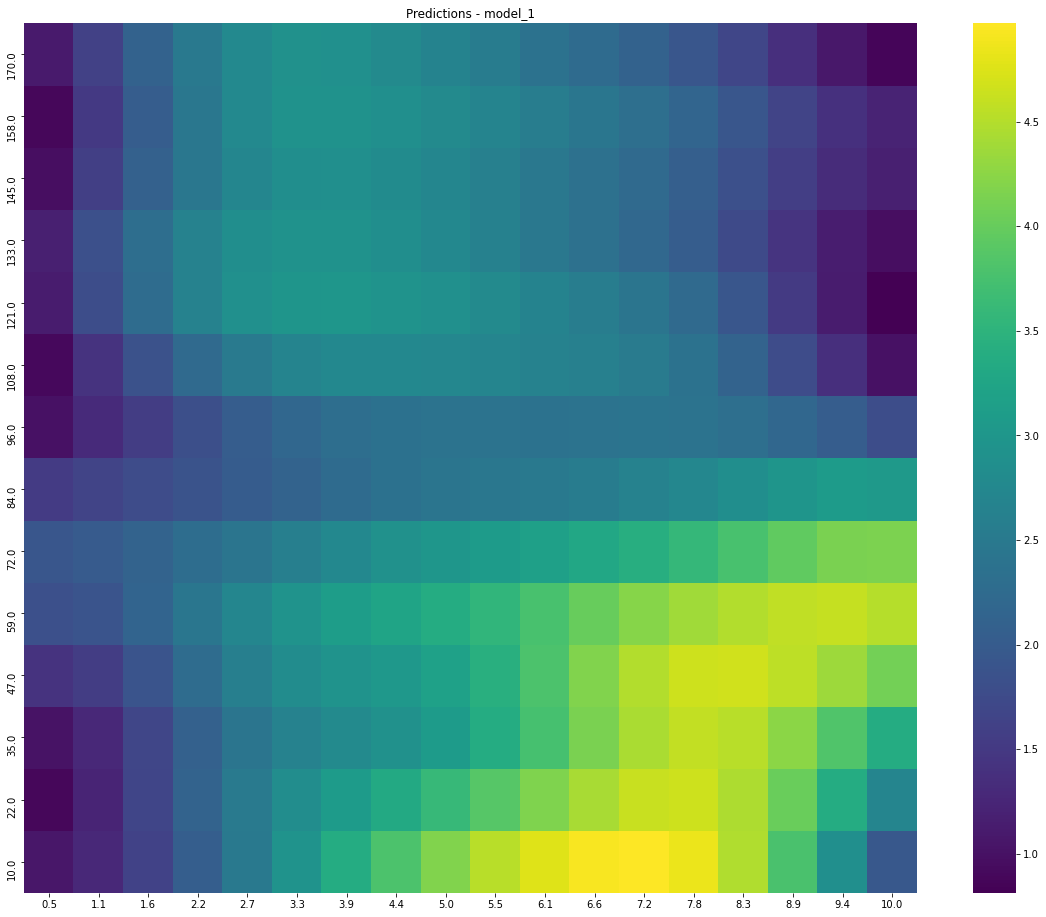

In [25]:
plt.figure(figsize=(20,16))
ax = sns.heatmap(s_1, cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(wd.round())
ax.set_xticklabels(ws.round(1))
ax.set_title('Predictions - model_1')

Text(0.5, 118.5, 'Prędkość wiatru [m/s]')

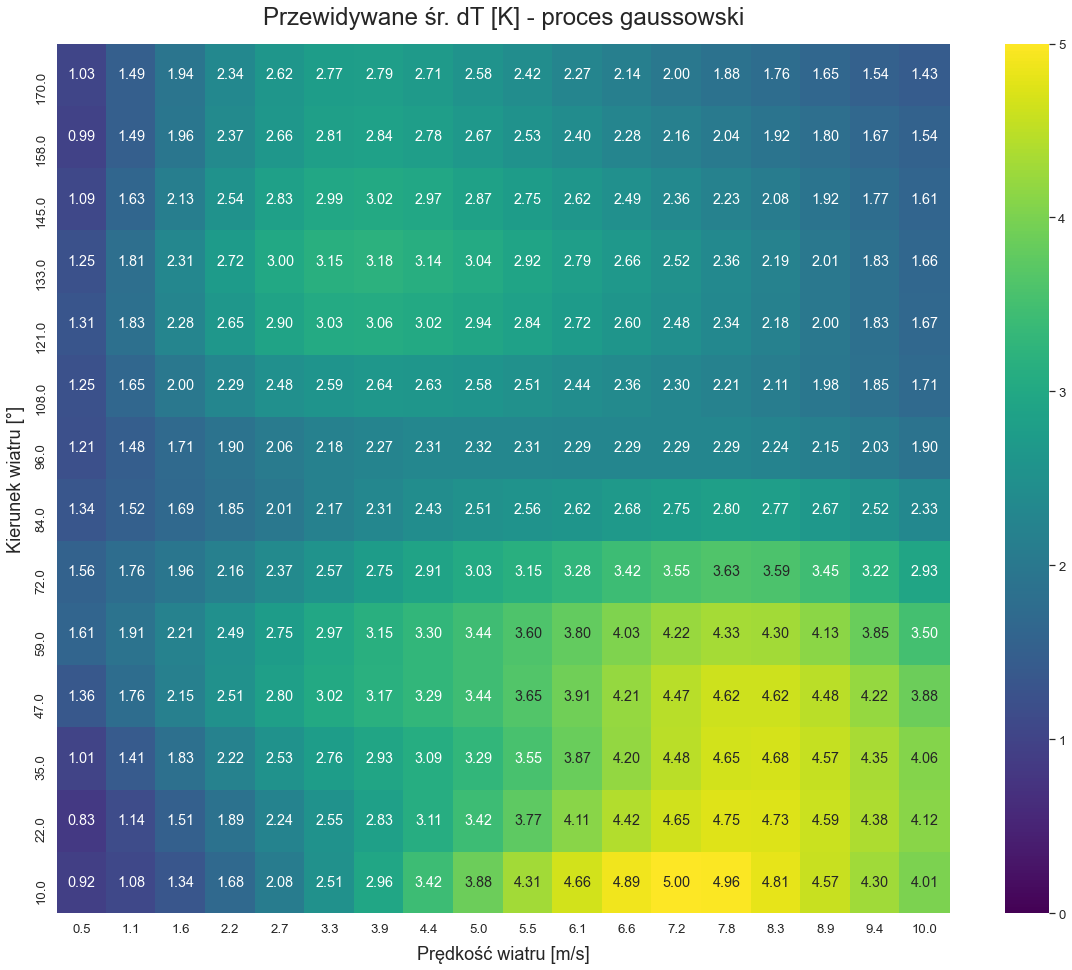

In [29]:
plt.figure(figsize=(20,16))
sns.set(font_scale=1.2)
ax = sns.heatmap(s_2, vmin=0, vmax=5, annot=True, fmt='.2f', cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(wd.round())
ax.set_xticklabels(ws.round(1))
ax.set_title('Przewidywane śr. dT [K] - proces gaussowski', fontsize=24, y=1.015)
ax.set_ylabel('Kierunek wiatru [\N{DEGREE SIGN}]', fontsize=18, labelpad=10)
ax.set_xlabel('Prędkość wiatru [m/s]', fontsize=18, labelpad=10)

Text(0.5, 1.0, 'Uncertainty - model_1')

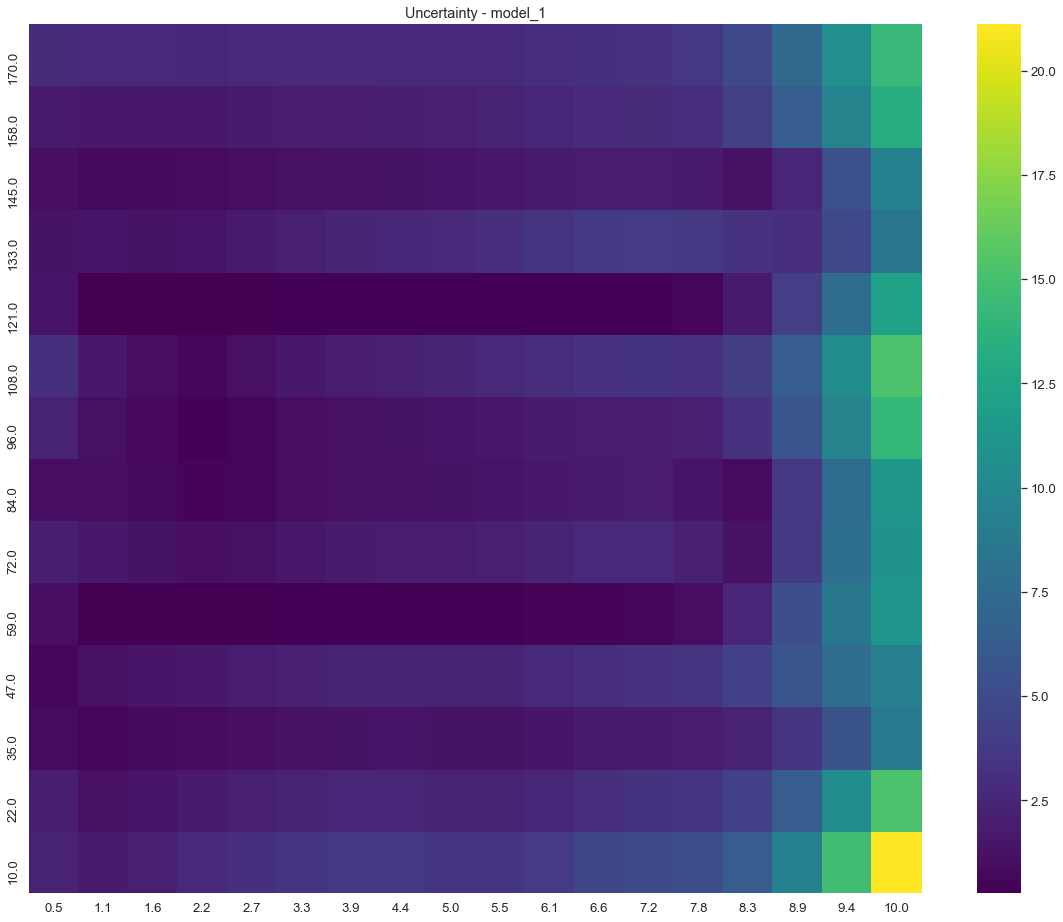

In [27]:
plt.figure(figsize=(20,16))
ax = sns.heatmap(sd_1, cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(wd.round())
ax.set_xticklabels(ws.round(1))
ax.set_title('Uncertainty - model_1')

Text(0.5, 118.5, 'Prędkość wiatru [m/s]')

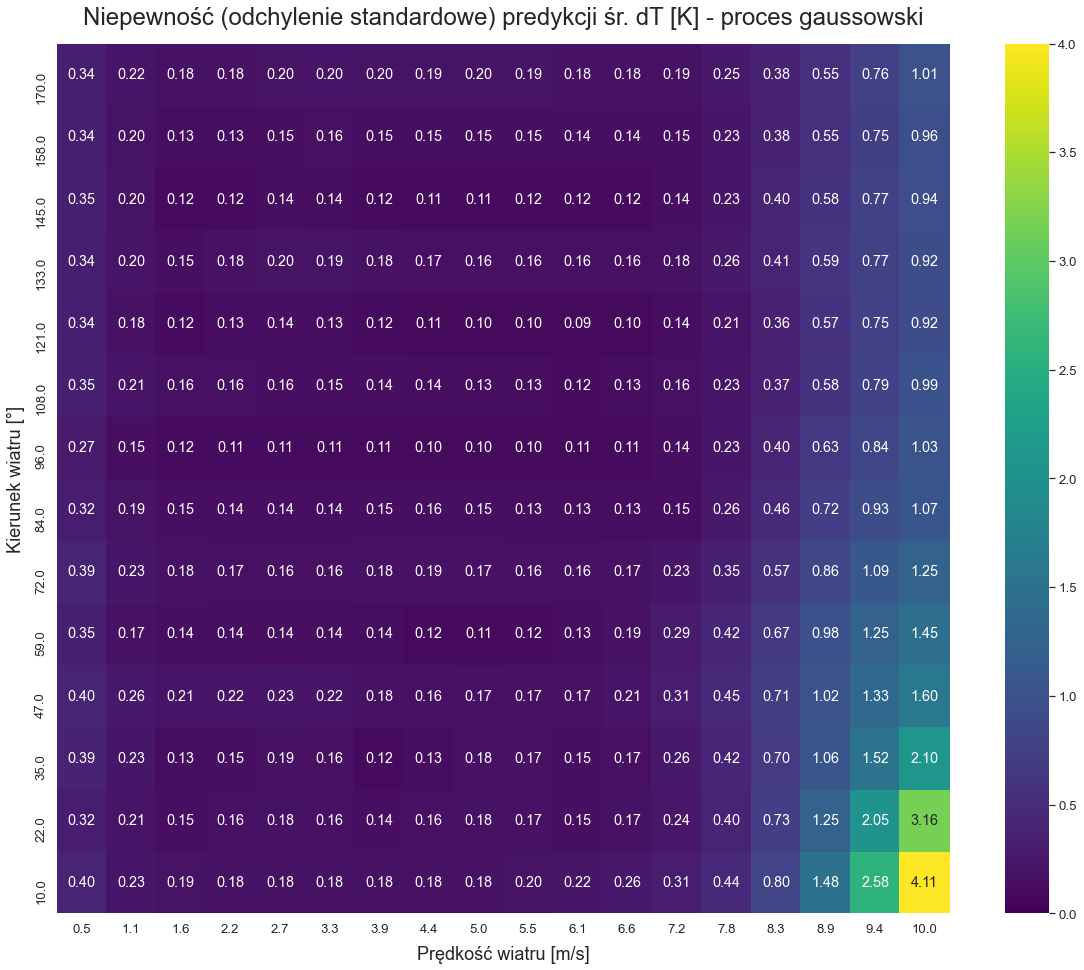

In [31]:
plt.figure(figsize=(20,16))
ax = sns.heatmap(sd_2, vmin=0, vmax=4, annot=True, fmt='.2f', cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(wd.round())
ax.set_xticklabels(ws.round(1))
ax.set_title('Niepewność (odchylenie standardowe) predykcji śr. dT [K] - proces gaussowski', fontsize=24, y=1.015)
ax.set_ylabel('Kierunek wiatru [\N{DEGREE SIGN}]', fontsize=18, labelpad=10)
ax.set_xlabel('Prędkość wiatru [m/s]', fontsize=18, labelpad=10)

In [36]:
print(wd.round(0))

[ 10.  22.  35.  47.  59.  72.  84.  96. 108. 121. 133. 145. 158. 170.]
